# Feature Extraction (Deep Learning Features)

## Part 3

**Author**: Maleakhi Agung Wijaya  
**Email**: maw219@cam.ac.uk  
**Description**: This file contains code for extracting deep learning features. We considered using transfer learning using VGG16, fine-tuned with the shell datasets and image augmentation as feature extractors. See part 1 for purely transfer learning where all weights of pretrained networks are freezed and see part 3 for transfer learning using random weights and autoencoders as feature extractors.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px
import plotly.graph_objects as go
import scipy.io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
import pickle
from scipy.spatial.distance import cdist
from sklearn.decomposition import IncrementalPCA, TruncatedSVD
from sklearn.random_projection import SparseRandomProjection

# Images
import os
import cv2
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.style as style
from skimage.io import imread, imshow
import re

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras import optimizers
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, backend as K, callbacks, losses
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [2]:
%run Utilities.ipynb

## Colab Section

The following section is ran on Google Colab since I needed GPU to fine-tuned the VGG16 model. I only fine-tuned the last convolutional block (block 5).

In [ ]:
# Get labels for each image, extract
path = 'drive/MyDrive/shell_species'
y_species = []
filenames = []
for _, _, files in os.walk(os.path.join(path, "shell_species_134_data")):
    for file in files:
        label = re.search(r"\d", file)
        idx_label = label.start() - 1
        y_species.append(file[:idx_label])
        filenames.append(file)

In [ ]:
le = LabelEncoder()
y_species = le.fit_transform(y_species) # categorise conversion from string for processing

# Dictionary for flow_from_dataframe
dict_df = {
    "x": filenames,
    "y": y_species
}
df = pd.DataFrame(dict_df)
df.head()

In [ ]:
path = os.path.join(path, "shell_species_134_data")

In [ ]:
# Construct data generator (with image augmentation)
datagen = ImageDataGenerator(
    rescale=1./255, # normalise the images
    validation_split=0.1,
    dtype=tf.float32,
    zoom_range=0.2, 
    rotation_range=30, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2
)

# Training and validation for autoencoders
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=path,
    x_col="x",
    y_col="y",
    target_size=(224, 224),
    batch_size=64,
    class_mode="raw",
    seed=123,
    subset="training",
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=path,
    x_col="x",
    y_col="y",
    target_size=(224, 224),
    batch_size=64,
    class_mode="raw",
    seed=123,
    subset="validation",
    shuffle=True
)

In [ ]:
VGG_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Set non trainable in our case
# Frozen all layers except the last CNN block
for layer in VGG_model.layers:
    layer.trainable=False

In [ ]:
# Make sure you have frozen the correct layers
for i, layer in enumerate(VGG_model.layers)[:15]:
    print(i, layer.name, layer.trainable)

In [ ]:
# Add top layers to the VGG model
x = VGG_model.output
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(134, activation="softmax")(x)
transfer_model= Model(inputs=VGG_model.input, outputs=x)

In [ ]:
# Set callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:
learning_rate= 5e-5
transfer_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])
history = transfer_model.fit(train_generator, 
                             validation_data=(validation_generator), 
                             epochs=100, shuffle=True,
                             callbacks=[lr_reduce, checkpoint], verbose=1)

## Pretrained VGG16
This section load the VGG16 finetuned model to be used as a feature extractor.

In [3]:
filenames = sorted(os.listdir(SHELL_IMAGES_DATA))
X_species, y_species = preprocess_x_y(filenames)
le = LabelEncoder()
y_species = le.fit_transform(y_species)

1


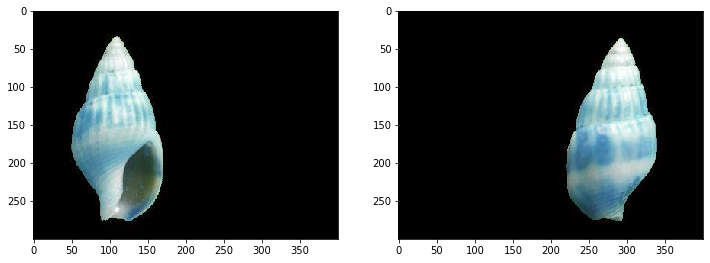

In [4]:
# Test visualise image
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print(y_species[12])
image1 = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_species[112][0]))
image2 = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_species[112][1]))
ax1.imshow(image1)
ax2.imshow(image2)

plt.show()

In [9]:
# model = load_model("drive/MyDrive/fine_tuned_vgg16_model")
# finetuned model located on drive

In [11]:
# Set non trainable in our case
for layer in model.layers:
    layer.trainable=False

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Feature Extraction

In [46]:
# Store features
X_features_vgg_a = []
X_features_vgg_b = []

In [48]:
### This cells only for extracting A (cannot do both at the same time,
# memory issue)
for X in tqdm(X_species):
    X_a = X[0] # A position
    X_b = X[1] # B position
    
    # Open the image in gray scale
    image_a = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_a), cv2.IMREAD_COLOR)
    image_b = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_b), cv2.IMREAD_COLOR)
    
    # Preprocess the image
    image_a = cv2.resize(image_a, (224, 224))
    image_b = cv2.resize(image_b, (224, 224))
    
    image_a = cv2.cvtColor(image_a, cv2.COLOR_RGB2BGR)
    image_a = image_a / 255.0
    image_a = np.reshape(image_a, (-1, 224, 224, 3))
    
    image_b = cv2.cvtColor(image_b, cv2.COLOR_RGB2BGR)
    image_b = image_b / 255.0
    image_b = np.reshape(image_b, (-1, 224, 224, 3))
    
    # Block 1 - fc
    X_features_vgg_a.append(model.predict(image_a).flatten())
    X_features_vgg_b.append(model.predict(image_b).flatten())

In [49]:
## Save objects
save_object(X_features_vgg_a, "../results/fine_tuned_vgg16_a.pickle")
save_object(X_features_vgg_b, "../results/fine_tuned_vgg16_b.pickle")

### Further Preprocessing

In [50]:
X_inception_a = load_object("../results/fine_tuned_vgg16_a.pickle")
X_inception_b = load_object("../results/fine_tuned_vgg16_a.pickle")

# Reshape 
X_inception_a = np.reshape(X_inception_a, (1340, -1))
X_inception_b = np.reshape(X_inception_b, (1340, -1))

# Dimensionality reduction using PCA as we have too many
# features at the moment.
pca = PCA(n_components=.95)
X_inception_a = pca.fit_transform(X_inception_a)
X_inception_b = pca.fit_transform(X_inception_b)

print(X_inception_a.shape)
print(X_inception_b.shape)

X_vgg = np.concatenate((X_inception_a, X_inception_b), axis=1)
save_object(X_vgg, "../results/X_vgg_finetuned.pickle")

(1340, 439)
(1340, 439)


In [5]:
# Load
X_vgg = load_object("../results/X_vgg_finetuned.pickle")
scaler = StandardScaler()
X_vgg_scaled = scaler.fit_transform(X_vgg)

### Classification

#### Standard ML Models

In [6]:
## Hyperparameter configurations and result storage
param_grid_svc = {
    # random search varying the parameter
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': ["scale", "auto"], 
    'kernel': ["rbf", "linear"]
}

param_grid_rf = { 
    'n_estimators': [10, 100, 200],
    'criterion' :['gini', 'entropy']
}

# Used to store results for different feature sets
list_dict_results = []

In [7]:
## Loop configuration
feature_sets = [
    (X_vgg, y_species),
    (X_vgg_scaled, y_species),
]
feature_sets_name = [
    "fine-tuned vgg",
    "fine-tuned vgg scaled",
]

## Classifier and hyperparameter loops
param_grids = [param_grid_svc, param_grid_rf]
classifiers_name = ["svc", "rf"]
classifiers = [SVC(), RandomForestClassifier()]
cmaps = ["plasma", "viridis"]

**************************************************
fine-tuned vgg
------------------------------
svc
Accuracy: 0.9604477611940299
F1: 0.9569651741293532


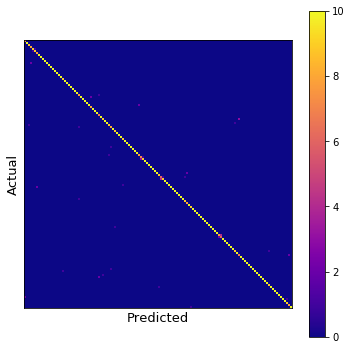


------------------------------
rf
Accuracy: 0.95
F1: 0.9444278606965174


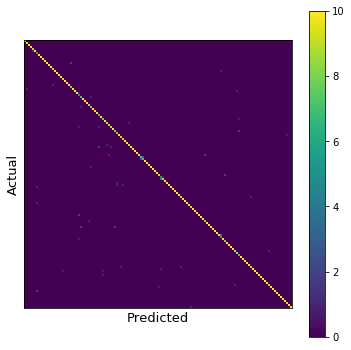


**************************************************
fine-tuned vgg scaled
------------------------------
svc
Accuracy: 0.953731343283582
F1: 0.9516086235489221


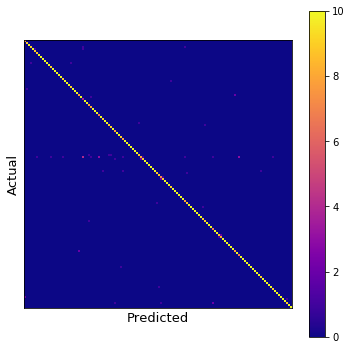


------------------------------
rf
Accuracy: 0.9462686567164178
F1: 0.941592039800995


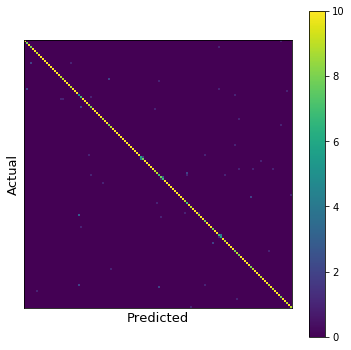

In [8]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    # Iterate over different classifiers
    for classifier, classifier_name, param_grid, cmap in zip(classifiers, 
                                                             classifiers_name, 
                                                             param_grids,
                                                             cmaps):
        print("-"*30)
        print(classifier_name)

        list_acc, list_cm, list_f1, list_cv_results = nested_cv_sklearn(classifier, param_grid, X, y, 5)
        # Add data to dict_results
        dict_results["accuracy"].append(list_acc)
        dict_results["f1"].append(list_f1)
        dict_results["cv_results"].append(list_cv_results)
        dict_results["cm"].append(list_cm)

        # Display accuracy, f1, confusion matrix
        print(f"Accuracy: {np.mean(list_acc)}")
        print(f"F1: {np.mean(list_f1)}")
        cm = sum(list_cm)

        plot_confusion_matrix(cm, cmap=cmap)

        print()
    
    list_dict_results.append(dict_results)

#### Neural Networks

In [9]:
## Loop configuration
feature_sets = [
    (X_vgg, y_species),
    (X_vgg_scaled, y_species),
]
feature_sets_name = [
    "fine-tuned vgg",
    "fine-tuned vgg scaled",
]

In [ ]:
param_grid_ffnn = { 
    'layer1_filters': [16, 32, 64, 128, 256],
    'layer2_filters': [16, 32, 64, 128, 256],
    'lr': np.random.uniform(0, 1, 5)
}

In [10]:
# Neural network configuration (simple one for standard)
# see more complex version on utilities.ipynb that are evaluated
# on other files.
optimizer = keras.optimizers.Adam()
batch_size = 64
no_epochs = 200

**************************************************
fine-tuned vgg
Accuracy: 0.8902985074626866
F1: 0.8539943141435679


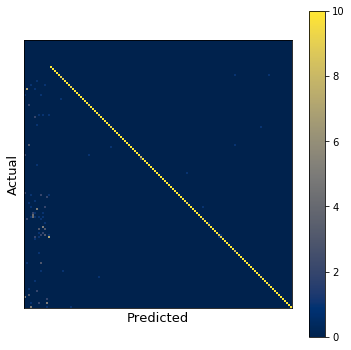


**************************************************
fine-tuned vgg scaled
Accuracy: 0.885820895522388
F1: 0.8486709310589907


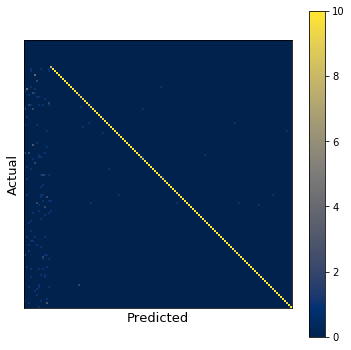

In [11]:
## Evaluation
# Iterate over different feature sets
for feature_set , feature_set_name in zip(feature_sets, feature_sets_name):

    print("*"*50)
    print(feature_set_name)
    
    X = feature_set[0]
    y = feature_set[1]
    
    dict_results = generate_dict_results()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    
    # Neural network training
    X = np.array(X)
    y = np.array(y)
    
    for train, test in kfold.split(X, y):
        grid_models = []
        performance = []
        for n1 in param_grid_ffnn["layer1_filters"]:
            for n2 in param_grid_ffnn["layer2_filters"]:
                for lr in param_grid_ffnn["lr"]:
                    model = keras.Sequential(
                            [
                                layers.Dense(n1, activation="relu"),
                                layers.Dense(n2, activation="relu"),
                                layers.Dense(134, activation="softmax"),
                            ]
                        )
                    optimizer = keras.optimizers.Adam(learnin_rate=lr)
                    
                    model.compile(loss="sparse_categorical_crossentropy",
                                 optimizer=optimizer,
                                 metrics=["accuracy"])

                    # Valid data
                    valid_range = int(0.2 * len(train))
                    valid = train[:valid_range]
                    train = train[valid_range:]
                    test_range = int(0.1 * len(valid))
                    test_inner = valid[:test_range]
                    valid = valid[test_range:]

                    # Early stopping callbacks
                    early_stopping = tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss', min_delta=0, patience=20,
                        mode="auto", restore_best_weights=False
                    )

                    # Fit data to model
                    history = model.fit(X[train], y[train],
                              batch_size=batch_size,
                              epochs=no_epochs, verbose=0, 
                              validation_data=(X[valid], y[valid]),
                              callbacks=[early_stopping])
                    
                    pred = model.predict(X[test_inner])
                    pred = np.argmax(pred, axis=1)
                    acc_inner = accuracy_score(pred, y[test_inner])
                    grid_models.append(model)
                    performance.append(acc_inner)
        
        # Refit the best model
        model = grid_models[np.argmax(performance)]
        
        # Generate generalisation metrics
        pred = model.predict(X[test])
        pred = np.argmax(pred, axis=1)
        cm = confusion_matrix(pred, y[test])
        acc = accuracy_score(pred, y[test])
        f1 = f1_score(pred, y[test], average="macro")
        
        # Add data to dict results
        dict_results["accuracy"].append(acc)
        dict_results["f1"].append(f1)
        dict_results["cm"].append(cm)
        
    # Display accuracy, f1, confusion matrix
    print(f"Accuracy: {np.mean(dict_results['accuracy'])}")
    print(f"F1: {np.mean(dict_results['f1'])}")
    plot_confusion_matrix(sum(dict_results['cm']), cmap="cividis")

    print()

    list_dict_results.append(dict_results)